# Exploring Wind Turbine Data

Dataset is available here: https://www.kaggle.com/datasets/psycon/wind-turbine-energy-kw-generation-data

Business Case:
- Knowing the generated power is required to sell it at the energy exchange. Accurate forecasts require fewer transactions at the balancing market which allows to maximize the profits.
- Next to selling active power, wind turbines can also deliver ancillary services to the grid, e.g. reactive power and voltage support, as well as frequency control. These services can be a potential source of revenue. 

Research Questions:
- What are the environmental conditions under which the wind turbine operates?
- Does this wind turbine deliver ancillary services to the grid?
- How often is the turbine limited by the wind, and how often by the grid?
- When and why does the wind turbine absorb power?
- How does a wind turbine behave when the power grid is down?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from math import ceil, floor, sqrt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

from utils import remove_outliers_iqr

## Loading the data

In [2]:
feature_units = pd.read_csv("kaggle_dataset/feature_units.csv")
features = pd.read_csv("kaggle_dataset/features.csv", index_col="Timestamp")
features.index = pd.to_datetime(features.index)

power = pd.read_csv("kaggle_dataset/power.csv", index_col="Timestamp")
power.index = pd.to_datetime(power.index)

In [3]:
feature_units.shape, features.shape, power.shape

((77, 2), (154262, 76), (136730, 1))

In [4]:
features.index.min(), features.index.max()

(Timestamp('2019-01-01 00:00:00'), Timestamp('2021-12-14 23:50:00'))

In [5]:
dataset_days = round(features.index.shape[0] / (6*24))
print(f"This dataset consists of {dataset_days} days")

This dataset consists of 1071 days


## Data Cleaning
Time series methods might have different handling of outliers, as we cannot simply drop them

In [6]:
total = features.isnull().sum().sort_values(ascending=False)
percent = (features.isnull().sum() / features.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent.round(2)], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
Blade-1 Set Value_Degree,5506,0.04
Proxy Sensor_Degree-135,5337,0.03
Moment D Direction,5231,0.03
Pitch Demand Baseline_Degree,5188,0.03
Temperature Heat Exchanger Converter Control Unit,5186,0.03
...,...,...
Temperature Gearbox Bearing Hollow Shaft,3732,0.02
Temperature Tower Base,3727,0.02
Gearbox_Distributor_Temperature,3689,0.02
Circuit Breaker cut-ins,3592,0.02


In [7]:
print("Before dropping rows with NaNs:", features.shape)
print("After dropping rows with NaNs:", features.dropna().shape)

Before dropping rows with NaNs: (154262, 76)
After dropping rows with NaNs: (17727, 76)


### Checking dtypes
All features are numerical, some might be continuous, some might be discrete.

In [8]:
sum(features.dtypes != float)

0

### Looking for duplicates

In [9]:
features.duplicated().sum()

0

### Looking for outliers

In [10]:
features_per_unit = feature_units.groupby('Unit').count().T
features_per_unit.columns

Index(['( )', '(%)', '()', '(Hz)', '(Nm)', '(V)', '(bar)', '(kNm)', '(kVAr)',
       '(kW)', '(mm)', '(mm/s²)', '(ms)', '(rpm)', '(°)', '(°C)'],
      dtype='object', name='Unit')

Temperatures in wind turbines do not reach 99999°C, these are missing values. After cleaning the temperatures seem realistic.

In [11]:
feature_units.loc[feature_units['Unit'] == '(V)', 'Column'].to_list()

['Voltage A-N', 'Voltage C-N', 'Voltage B-N', 'Converter Control Unit Voltage']

In [12]:
temperature_features = feature_units.loc[feature_units['Unit'] == '(°C)', 'Column'].to_list()
angle_features = feature_units.loc[feature_units['Unit'] == '(°)', 'Column'].to_list()

In [13]:
# Replaing 99999 in all features with a NaN
for col in features.columns:
    features[col].loc[features[col] == 99999] = np.nan

Some parts of the turbine on average are hotter than others. No part can be colder than -50°C, so these values are removed

(-10.0, 150.0)

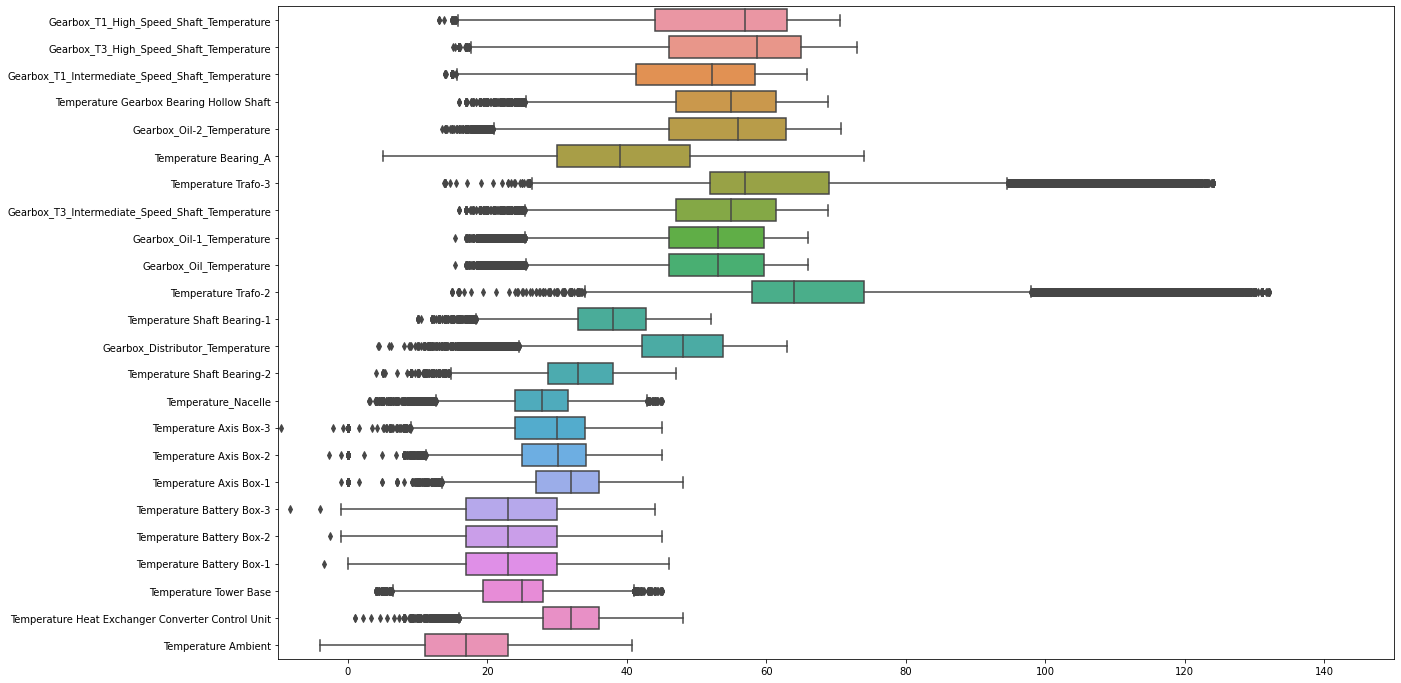

In [14]:
plt.figure(figsize=(20,12))
sns.boxplot(data=features[temperature_features], orient='h')
plt.xlim([-10, 150])

All angles should be in 0-360 degree range. 359-1 degree switches are handled in encoding.

In [15]:
n = floor(features[angle_features].min().min() / 360)

if n < 0:
    features[angle_features] += -n * 360
    features[angle_features] = features[angle_features] % 360
    
# (features[angle_features] % 360).describe()

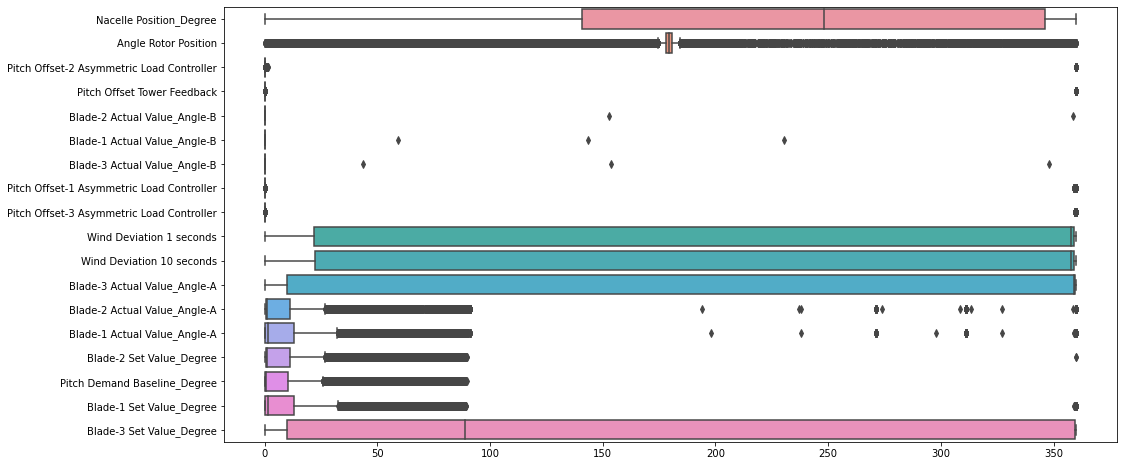

In [16]:
plt.figure(figsize=(16,8))
sns.boxplot(data=features[angle_features], orient='h')
plt.show()

### Removing outliers

In [17]:
# Remaining features
other = set(features.columns) - set(temperature_features + angle_features)

In [18]:
def find_outliers_iqr(X):
    for col in X.columns:
        feature = X[col]
        q1 = feature.quantile(0.25)
        q3 = feature.quantile(0.75)
        iqr = q3 - q1
        mask = feature.loc[((feature < (q1 - 1.5 * iqr)) | (feature > (q3 + 1.5 * iqr)))].index
        if len(mask) > 0:
            print(col, len(mask))

In [19]:
find_outliers_iqr(features[other])

C:\Users\danie\AppData\Local\Temp\ipykernel_18368\4260805748.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  find_outliers_iqr(features[other])


Scope CH 4 24241
Moment D Filtered 2247
Hydraulic Prepressure 7135
Proxy Sensor_Degree-225 785
Turbine State 28199
Operating State 27362
Converter Control Unit Voltage 3509
State and Fault 27521
Nacelle Revolution 21
Tower Accelaration Lateral Raw 22531
Reactive Power 1276
Converter Control Unit Reactive Power 1127
Proxy Sensor_Degree-135 1306
External Power Limit 16
Tower Acceleration Normal 5865
Torque 11998
Internal Power Limit 2253
Tower Deflection 12428
Tower Acceleration Lateral 3770
Proxy Sensor_Degree-45 719
Moment Q Direction 4877
Proxy Sensor_Degree-315 234
Moment Q Filltered 4848
Voltage C-N 266
N-set 1 27784
Tower Accelaration Normal Raw 17472
Torque Offset Tower Feedback 8581
Moment D Direction 2267
Line Frequency 3841
Voltage B-N 192
Voltage A-N 177


In [20]:
# print(features.isna().sum().sum())
# features = remove_outliers_iqr(features, other)
# print(features.isna().sum().sum())

## Exploratory Data Analysis

### Investigating correlations
Temperatures are correlated, because components in the nacelle heat up together. Hydraulic pressure is associated with the temperatures, perhaps due to thermal expansion of the fluid. 

Turbine and Operating State seem to be important features correlated with most of the control signals including blade angles and torque. Operating State might correspond to the control signal from the System Operator. 

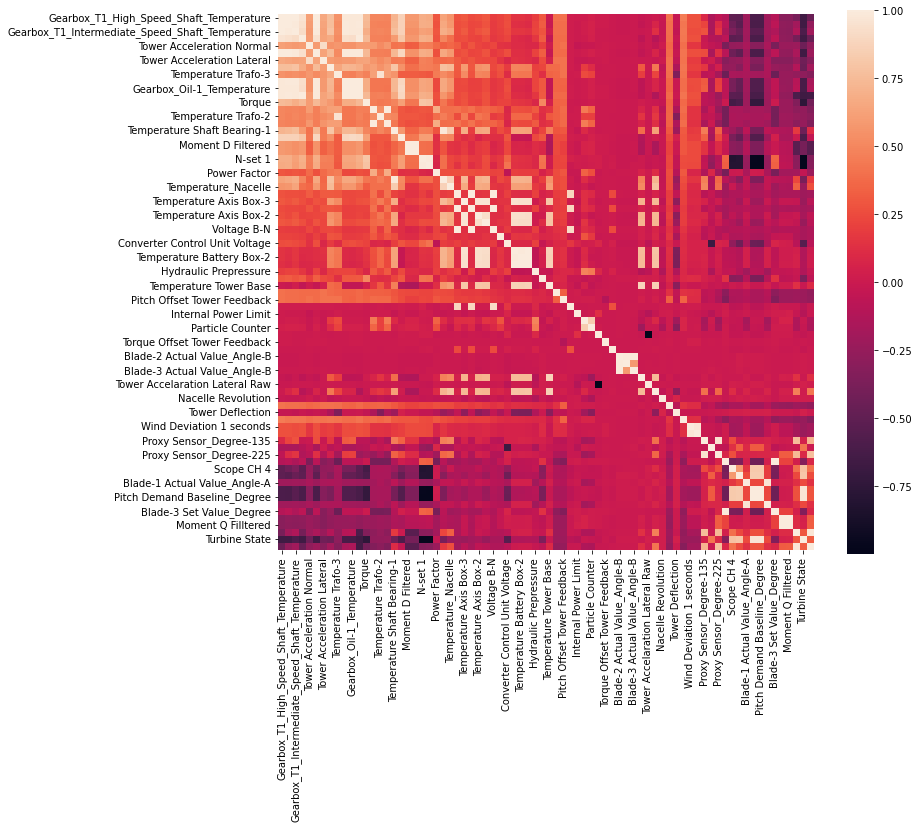

In [21]:
corr_matrix = features.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, square=True)
plt.show()

Heatmap above shows that torque is negatively correlated with wind turbine state. Torque has three distinct phases: when it is negative and active power generation is zero, so the turbine delivers ancillary services and the generator shaft is disconnected from the shaft connected with the rotor. Second phase is for torque in 0-100% which is the only time when active power is generated. In this phase reactive power can also be generated, if needed. Third phase is for torque exceeding 100% where neither active nor reactive power is generated, as this could damage the generator. 

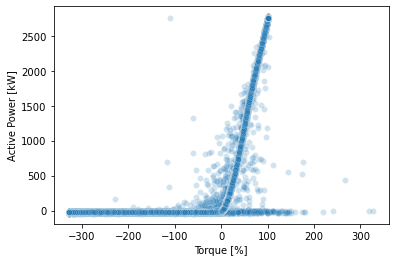

In [140]:
ax = sns.scatterplot(x=features['Torque'].loc[power.index], y=power["Power(kW)"], alpha=0.2)
ax.set_xlabel("Torque [%]")
ax.set_ylabel("Active Power [kW]")
plt.show()

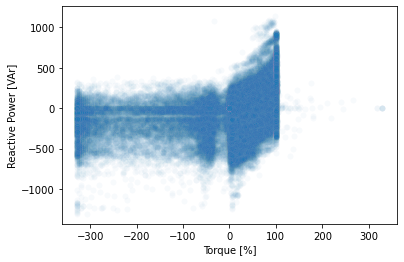

In [66]:
ax = sns.scatterplot(x=features['Torque'], y=features['Reactive Power'], alpha=0.03)
ax.set_xlabel("Torque [%]")
ax.set_ylabel("Reactive Power [VAr]")
plt.show()

__Hypothesis__: _Turbine State_ takes discrete values for most of the time, and is continuous during the transitions. This feature might indicate the control signals sent by the system operator. In the data there are 5 different states:
- State 1: Torque is between 0% and 100%, the turbine delivers active and reactive power.
- State 3: Torque is strongly negative and wind turbine delivers ancillary services.
- States 2, 4, and 5: Status Unknown

Operating State reveals similar behaviour as described above, state 16 corresponds to torque between 0 and 100%, so with active power generation. States 11 and 12 remain unknown.

<AxesSubplot:xlabel='Turbine State', ylabel='Torque'>

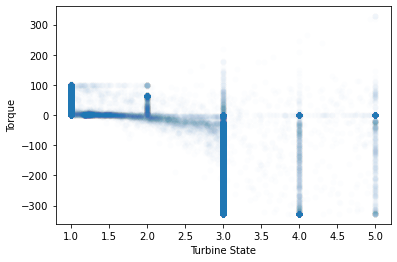

In [86]:
sns.scatterplot(x=features['Turbine State'], y=features['Torque'], alpha=0.01)
# sns.scatterplot(x=features['Operating State'], y=features['Torque'], alpha=0.01)

Wind turbine does not generate active power, but provides ancillary services to the grid for roughly 20% of time.

Text(0, 0.5, 'Cumulative Probability [-]')

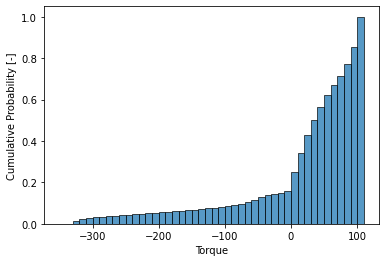

In [68]:
ax = sns.histplot(features['Torque'], binrange=(-350, 110), binwidth=10, stat="probability", cumulative=True)
ax.set_ylabel("Cumulative Probability [-]")

### Investigating Ambient Conditions
Nacelle heats up ~ linearly with ambient temperature, can be hotter than the surrounding air but never is colder. This makes sense, as power electronics inside the nacelle release heat.

Nacelle temperature seems independent of active and reactive power generated by the turbine, as well as torque of the rotor. Correlation between nacelle temperature and generated power could indicated damage in power electronic components (excess heating).

(0.0, 50.0)

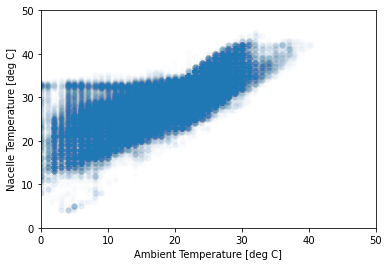

In [22]:
ax = sns.scatterplot(x=features['Temperature Ambient'], y=features['Temperature_Nacelle'], alpha=0.01)
ax.set_xlabel("Ambient Temperature [deg C]")
ax.set_ylabel("Nacelle Temperature [deg C]")
ax.set_xlim([0, 50])
ax.set_ylim([0, 50])

(0.0, 50.0)

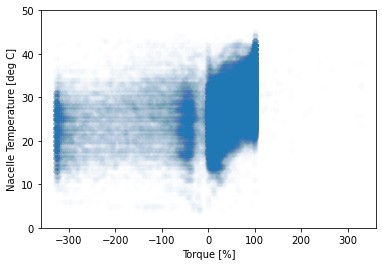

In [23]:
ax = sns.scatterplot(x=features['Torque'], y=features['Temperature_Nacelle'], alpha=0.01)
ax.set_xlabel("Torque [%]")
ax.set_ylabel("Nacelle Temperature [deg C]")
ax.set_ylim([0, 50])

### What influences active power generation?
Generation is sometimes limited by internal limit, but almost never by the external limit (power grid). It was checked that Internal Power Limit is independent of ambient temperature.

(0.0, 3000.0)

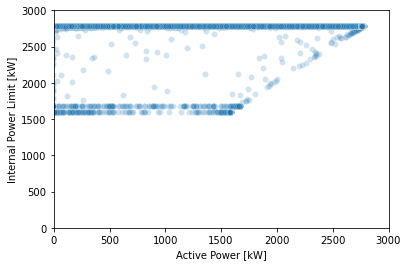

In [31]:
ax = sns.scatterplot(x=power["Power(kW)"], y=features['Internal Power Limit'].loc[power.index], alpha=0.2)
ax.set_xlabel("Active Power [kW]")
ax.set_ylabel("Internal Power Limit [kW]")
ax.set_xlim([0, 3000])
ax.set_ylim([0, 3000])

In [32]:
# s = sns.scatterplot(x=features['Temperature Ambient'], y=features['Internal Power Limit'], alpha=0.01)
# plt.xlim([-10, 60])

In [33]:
# This many times power production is limited by the grid 
(features['External Power Limit'] < features['Internal Power Limit']).sum()

6

### Analysing Conditions When Grid Frequency is far from 50Hz
What is the max margin around 50Hz tolerated by the grid? How does a wind turbine behave when there is no power in the grid?

In [107]:
grid_off = features.loc[power.index].loc[(features['Line Frequency'] < 49) | (features['Line Frequency'] > 51)].copy()
len(grid_off)

83

When power grid is down wind turbine pitch control turns the blades to 90 degrees with respect to the wind, so the blades do not rotate and no power is generated. This is necessary for safety reasons, as the grid cannot absorbe the generated power. 

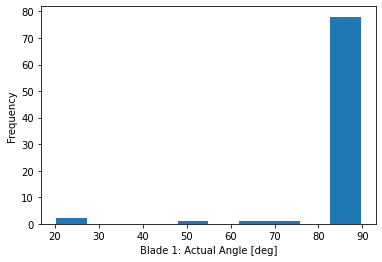

In [108]:
grid_off['Blade-1 Actual Value_Angle-A'].plot(kind='hist')
plt.xlabel("Blade 1: Actual Angle [deg]")
plt.show()

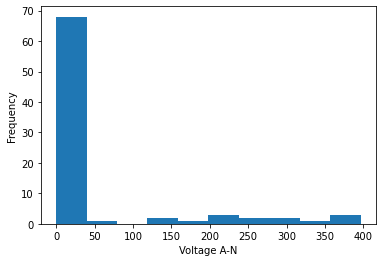

In [136]:
grid_off['Voltage A-N'].plot(kind='hist')
plt.xlabel("Voltage A-N")
plt.show()

### When and why is the active power negative?

Wind turbine has certain self-consumption of electricity which is used to maintain communication and control systems operation, heat up oil in the gearbox, power positional lights, etc. More complete list of power loads in wind turbines can be found here: http://www.aweo.org/windconsumption.html

In [36]:
power['Power(kW)'].min()

-48.5966682434082

Quality check: power factor looks correct, as maximum active power is generated for power factor equal 1 or -1 which corresponds to no reactive power generation. Active power increases with power factor becoming further from 0. 

Text(0, 0.5, 'Active Power [kW]')

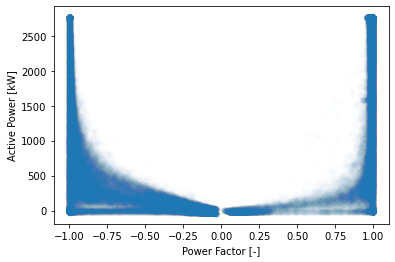

In [141]:
ax = sns.scatterplot(x=features['Power Factor'].loc[power.index], y=power['Power(kW)'], alpha=0.01)
ax.set_xlabel("Power Factor [-]")
ax.set_ylabel("Active Power [kW]")

Quality check: power factor vs. reactive power also looks as expected. Reactive power has large absolute values when power factor is close to zero. Reactive power is zero when power factor is one. 

Text(0, 0.5, 'Reactive Power [kVAr]')

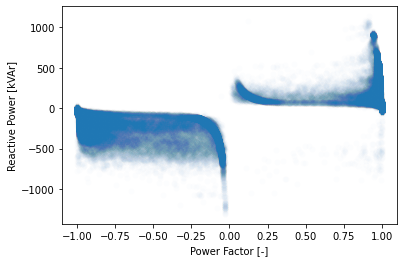

In [142]:
ax = sns.scatterplot(x=features['Power Factor'], y=features['Reactive Power'], alpha=0.01)
ax.set_xlabel("Power Factor [-]")
ax.set_ylabel("Reactive Power [kVAr]")

__Why does the reactive power become negative?__

count    23705.000000
mean      -174.314340
std        224.428241
min      -1307.984985
25%       -311.864990
50%       -143.386673
75%          0.000000
max        474.959991
Name: Reactive Power, dtype: float64


Text(0.5, 0, 'Reactive Power When Active Power is Negative')

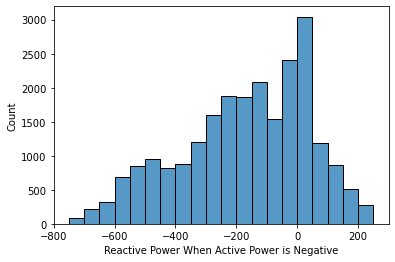

In [41]:
mask = power.loc[power['Power(kW)'] < 0].index
features_neg_power = features.loc[mask]
print(features_neg_power['Reactive Power'].describe())

h = sns.histplot(features_neg_power['Reactive Power'], binrange=(-750, 250), binwidth=50)
h.set_xlabel("Reactive Power When Active Power is Negative")

Text(0.5, 0, 'Power Factor When Active Power is Negative')

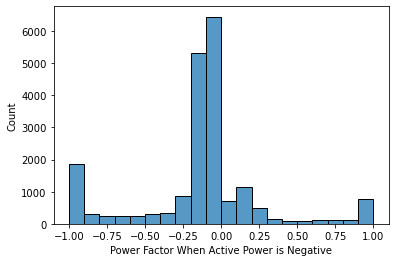

In [42]:
h = sns.histplot(features_neg_power['Power Factor'], binrange=(-1, 1), binwidth=0.1)
h.set_xlabel("Power Factor When Active Power is Negative")

### No Toruqe Conditions - Self Consumption

In [43]:
no_wind_features = features.loc[features['Torque'] == 0]

Text(0.5, 0, 'Active Power [kW]')

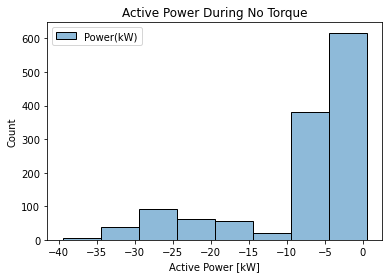

In [44]:
h = sns.histplot(power.loc[features['Torque'] == 0], binwidth=5)
h.set_title("Active Power During No Torque")
h.set_xlabel("Active Power [kW]")

<AxesSubplot:xlabel='Reactive Power', ylabel='Count'>

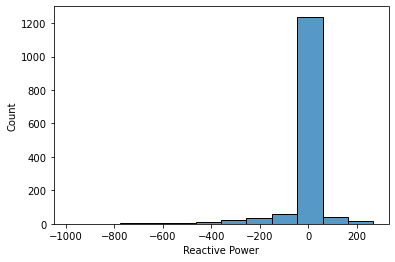

In [111]:
sns.histplot(no_wind_features['Reactive Power'])

### Control System
Discrepancy between the set and actual angle of the blade can be calculated. This the delay or noise in the control signal influence on power factor or active power could be investigated.

In [46]:
(features['Blade-1 Set Value_Degree'] - features['Blade-1 Actual Value_Angle-A']).describe()

count    141498.000000
mean         -0.744932
std          19.091107
min        -359.999823
25%          -0.003159
50%           0.000014
75%           0.003128
max         359.999355
dtype: float64

### Voltage and Reactive Power
Wind turbines are often in remote locations and therefore, they need to maintain line voltage by producing reactive power. Therefore, line-to-neutral voltage and reactive power are correlated. Note that voltage signals are not sinusoidal because of the 10 min sampling frequency.

In [47]:
features[['Voltage A-N', 'Voltage B-N', 'Voltage C-N']].describe()

,Voltage A-N,Voltage B-N,Voltage C-N
count,148288.000000,149093.000000,148965.000000
mean,400.137964,396.773473,397.090545
std,10.177121,9.717684,9.637928
min,0.000000,0.000000,0.000000
25%,397.079987,394.241669,394.236664
50%,400.583344,397.656677,397.723328
75%,403.994995,399.921661,400.556671
max,415.266663,410.956665,412.161652


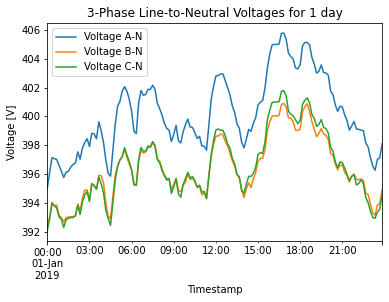

In [48]:
features[['Voltage A-N', 'Voltage B-N', 'Voltage C-N']].iloc[0:6*24].plot()
plt.title("3-Phase Line-to-Neutral Voltages for 1 day")
plt.ylabel("Voltage [V]")
plt.show()

(380.0, 420.0)

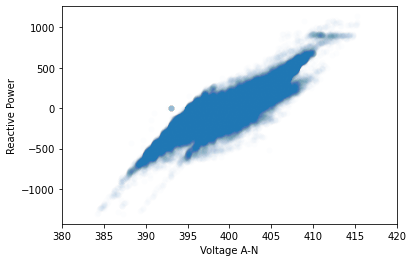

In [49]:
s = sns.scatterplot(x=features['Voltage A-N'], y=features['Reactive Power'], alpha=0.01)
s.set_xlim([380, 420])

### Active power generation per month

Text(0, 0.5, 'Active Power [kW]')

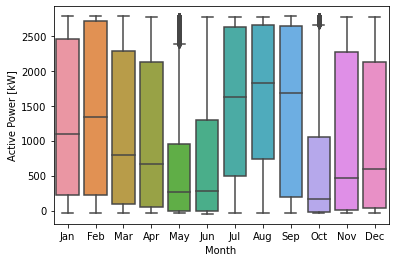

In [129]:
# plt.figure(figsize=(16,8))
ax = sns.boxplot(data=power, x=power.index.month, y=power['Power(kW)'])
ax.set_xticklabels(["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
ax.set_xlabel("Month")
ax.set_ylabel("Active Power [kW]")

## Conclusions:
- Data quality is sufficient to proceed with the analysis.
- Active power generation is limited by the internal limit which means the turbine is rarely limited by the grid. Grid frequency is very stable and stays within +-0.5 Hz almost at all times.
- When the power grid is down, wind turbine rotates its blades perpendicularly to the wind not to generate power which cannot be absorbed.
- Wind turbine sometimes consumes active power and this consumption can be as high as 48 kW. 
- For 15-20% of time the turbine delivers ancillary services to the grid, e.g. generates reactive power to maintain line voltage.
- Torque describes rotations of the high speed shaft, not of the shaft connected with the wind turbine rotor. Active power generation happens when torque is in 0-100% range which is true for 85% of time. When torque > 100% the wind turbine does not generate active power to prevent damage. When torque is negative the turbine delivers ancillary services to the grid.
- _Turbine State_ and _Operating State_ describe control signal from the System Operator and are expected to have high importance when predicting active power output. This is because System Operator can prioritize tasks other than active power generation.
- Active power generation is the lowest in May and June, and the highest during the summer: July, August, September. In general, power output is larger in summer than in winter. 